<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [1]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.utils import Sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

[MacBook-Pro-de-Genereux.local:27042] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/3973316608/sm_segment.MacBook-Pro-de-Genereux.501.ecd40000.0 could be created.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Pretrained model Utils

In [3]:
# Paths
gene_info_path = "../data/gene_info.json"
dataset_path = "../data/one_vs_other/"
pretrained_model_path = "../notebook/Output/Model"
gene_bank_folder = "../data/raw_data"

# Load gene info
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# Utils
def load_models(k):
    """Load multiple models from given paths."""
    models_dict = []
    for gene, info in gene_info.items():
        model_path = f"{pretrained_model_path}/{info['file_code']}/FEEDFORWARD_k{k}.keras"
        meta_path  = f"{pretrained_model_path}/{info['file_code']}/meta.json"
        model = load_model(model_path)
        with open(meta_path, 'r') as json_file:
            meta = json.load(json_file)
        feature = meta[gene.replace('/', '__')][f"FEEDFORWARD_k{k}"]["features_mask"].values()
        models_dict.append((model, feature))
    return models_dict

### 3 - Load data

In [4]:
GENE_FAMILY = gene_info.keys()
gene_families_index = {gene_family: index for index, gene_family in enumerate(GENE_FAMILY)}

In [5]:
def build_combined_df():
    combined_train_df = pd.DataFrame()
    combined_test_df  = pd.DataFrame()
    for gene_family, info in gene_info.items():
        file_path = "../data/raw_data/"+info["filename"]
        df = fasta.read(file_path, gene_families_index[gene_family])
        
        # Split the data to take 80%
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        
        # Combine the DataFrame
        combined_train_df = pd.concat([combined_train_df, train_df], ignore_index=True)
        combined_test_df = pd.concat([combined_test_df, test_df], ignore_index=True)
    
    return combined_train_df, combined_test_df


# Build the combined DataFrame
train_df, test_df = build_combined_df()

* **Predict on train**

In [6]:
train_df.shape

(256273, 4)

# 3 - Pipeline

* **Data Mask fit**

In [7]:
class DataFrameProcessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe.sort_index(axis=1)
    
    def fit_mask(self, feature_array):
        df_copy = self.dataframe.copy()
        existing_columns = df_copy.columns.intersection(feature_array)
        df_copy = df_copy[existing_columns]
        new_df = pd.DataFrame(0, index=df_copy.index, columns=feature_array)
        for col in existing_columns:
            new_df[col] = df_copy[col]
        return new_df

    def get(self):
        return self.dataframe

* **Data Generator**

In [8]:
class DataGenerator(Sequence):
    def __init__(self, df, models_dict, gene_info, batch_size=32, k=2):
        self.df = df
        self.models_dict = models_dict
        self.gene_info = gene_info
        self.batch_size = batch_size
        self.k = k
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]
        X, y = self.__data_generation(batch_df)
        return X, y

    def __data_generation(self, batch_df):
        kmer_features, y_kmer, _ = DNA.build_kmer_representation_v2(train_data, k=self.k)
        X_kmer = DataFrameProcessor(kmer_features)
        
        predictions = []
        for model, feature in tqdm(self.models_dict):
            X_test = X_kmer.fit_mask(feature)
            pred = model.predict(X_test, verbose=0)
            predictions.append(pred)
        predictions = np.array(predictions)
        shape = predictions.shape
        X_batch = predictions.reshape(shape[0], shape[1]).T
        y_batch = np.array(y_kmer)
        
        return X_batch, y_batch

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/MetaClassifier/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
models_dict = load_models(k)

In [11]:
def pipline_data_transform(df):
    kmer_features, y_kmer, _ = DNA.build_kmer_representation_v2(df, k=2)
    X_kmer = DataFrameProcessor(kmer_features)
    
    predictions = []
    for model, feature in tqdm(models_dict):
        X_test = X_kmer.fit_mask(feature)
        pred = model.predict(X_test, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    shape = predictions.shape
    X = predictions.reshape(shape[0], shape[1]).T
    y = np.array(y_kmer)
    return X, y

In [12]:
X_train, y_train = pipline_data_transform(train_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [06:14<00:00,  6.45s/it]


In [13]:
X_test, y_test = pipline_data_transform(test_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:35<00:00,  1.65s/it]


In [14]:
X_train, X_val, y_train,y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

In [15]:
X_test.shape

(64097, 58)

In [16]:
#train_data, validation_data = train_test_split(train_df, train_size=0.8, stratify=train_df['class'])
#batch_size=4096
#training_generator   = DataGenerator(train_data, models_dict, gene_info, batch_size=batch_size, k=k)
#validation_generator = DataGenerator(validation_data, models_dict, gene_info, batch_size=batch_size, k=k)
#test_generator       = DataGenerator(test_df, models_dict, gene_info, batch_size=batch_size, k=k)

* <span style="color: blue; font-weight: bold;">FEED-FORWARD META CLASSIFIER</span>

In [17]:
X_train[0]

array([2.96968705e-04, 3.24132032e-09, 3.37998899e-05, 2.15123082e-03,
       4.05658147e-06, 2.03565520e-04, 2.69464077e-03, 5.96138416e-04,
       4.47974591e-09, 8.63242967e-05, 3.76428346e-07, 1.09511711e-04,
       3.89477296e-04, 1.54567836e-03, 1.48132874e-03, 2.92969472e-03,
       2.60896322e-05, 6.35423698e-03, 7.12845707e-04, 1.01781276e-03,
       1.14122295e-05, 2.15449743e-03, 6.23077949e-06, 7.28692161e-04,
       1.86584628e-04, 4.07982116e-05, 1.76298097e-04, 5.27360663e-03,
       1.08120985e-04, 2.12812243e-04, 4.02113292e-05, 5.21219845e-05,
       9.98317480e-01, 9.00127172e-01, 2.64641852e-03, 1.14781897e-05,
       1.11251778e-03, 1.22633530e-03, 3.87218734e-03, 1.38920233e-01,
       7.23369376e-05, 7.70564875e-05, 4.17777279e-04, 3.07479146e-04,
       3.86391272e-04, 1.79455063e-04, 4.22122394e-04, 2.91663298e-07,
       1.87894275e-05, 6.98659323e-06, 4.91156425e-06, 6.73589762e-03,
       1.24294276e-03, 8.31199461e-04, 1.47738410e-02, 4.46570484e-04,
      

In [21]:
name="META_k2"
def build_stage2_classifier():
    meta_model = Sequential(name=name)
    meta_model.add(Input(shape=(len(models_dict),)))
    meta_model.add(Dense(128, activation='relu'))
    meta_model.add(Dropout(0.1))
    meta_model.add(Dense(64, activation='relu'))
    meta_model.add(Dense(len(gene_info), activation='softmax'))
    meta_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    meta_model.summary()
    return meta_model
    
# Build
meta_model = build_stage2_classifier()
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

# Train
#history = meta_model.fit(training_generator, validation_data=validation_generator, epochs=10, callbacks=[stop_callback, save_callback])
history = meta_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate
# Evaluate and score
test_scores = meta_model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "META_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 58)             │         3,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,578 (76.48 KB)

 Trainable params: 19,578 (76.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 3s 721us/step - accuracy: 0.7548 - loss: 1.0334 - val_accuracy: 0.8783 - val_loss: 0.3920
Epoch 2/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - accuracy: 0.8754 - loss: 0.4030 - val_accuracy: 0.8870 - val_loss: 0.3700
Epoch 3/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - accuracy: 0.8838 - loss: 0.3760 - val_accuracy: 0.8906 - val_loss: 0.3628
Epoch 4/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.8870 - loss: 0.3672 - val_accuracy: 0.8938 - val_loss: 0.3518
Epoch 5/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 709us/step - accuracy: 0.8912 - loss: 0.3529 - val_accuracy: 0.8943 - val_loss: 0.3467
Epoch 6/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 698us/step - accuracy: 0.8938 - loss: 0.3463 - val_accuracy: 0.8955 - val_loss: 0.3453
Epoch 7/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 700us/step - accuracy: 0.8930 - loss: 0.3461 - val_accuracy: 0.8968 - val_loss: 0.3415
Epoch 8/100
3204/3204 ━━━━━━━━━━━━━━━━━━━━ 2s 704us/step - accuracy: 

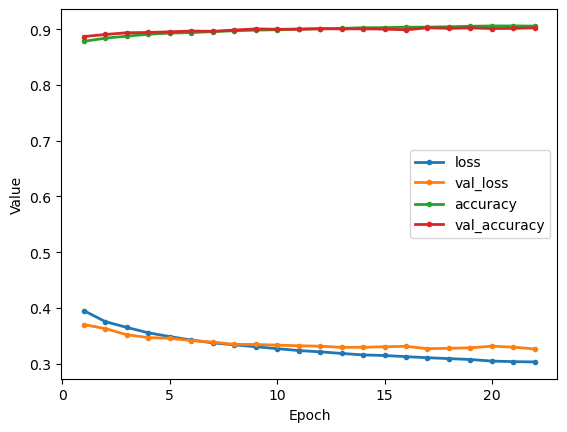

In [22]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [ ]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################